In [150]:
#Imports
import random
import math
import matplotlib.pyplot as plt
import scipy as sp
# import sklearn
import sklearn.datasets
import sklearn.decomposition
from sklearn.utils import Bunch
import numpy as np
import pandas as pd
from functools import cmp_to_key
from itertools import combinations

## Abstract Data Type

In [151]:
#definição do tipo abstrato Point
class Point:
	def __init__(self, x, y):
		self.x = x
		self.y = y

	def __str__(self):
		return f'({self.x}, {self.y}) ' #auxiliar para imprimir o ponto e conferir se as funções estão corretas

	def __repr__(self):
		return str(self)

	def __lt__(self, other):
		if self.x < other.x:
			return True
		elif self.x == other.x:
			if self.y < other.y:
				return True
		return False


#definição do tipo abstrato Segment contendo 2 pontos e os coeficientes a e b da reta
class Segment:
	def __init__(self, p1, p2):
		self.p1 = p1
		self.p2 = p2
		if p1.x == p2.x:
			p2.x += 0.0001
		self.a = (p2.y - p1.y)/(p2.x - p1.x)
		self.b = p1.y - self.a*p1.x

	def __str__(self):
		return f'({self.p1}, {self.p2})' #auxiliar para imprimir o segmento e conferir se as funções estão corretas

	def __repr__(self):
		return str(self)

	def __lt__(self, other):
		thisY = self.a * other.p1.x + self.b
		otherY = other.a * self.p1.x + other.b
		if self.p1.x < other.p1.x:
			if thisY < other.p1.y:
				return True
		elif self.p1.x == other.p1.x:
			if self.p1.y < other.p1.y:
				return True
		else:
			if self.p1.y < otherY:
				return True
		return False

	def __gt__(self, other):
		thisY = self.a * other.p1.x + self.b
		otherY = other.a * self.p1.x + other.b
		if self.p1.x < other.p1.x:
			if thisY > other.p1.y:
				return True
		elif self.p1.x == other.p1.x:
			if self.p1.y > other.p1.y:
				return True
		else:
			if self.p1.y > otherY:
				return True


#definição do tipo abstrato EndPoint contendo um ponto, ponteiro para o seguimento, e uma flag para saber se é o ponto inicial ou final do seguimento
class EndPoint:
	def __init__(self, point, segment, isLeft):
		self.point = point
		self.segment = segment
		self.isLeft = isLeft

	def __str__(self):
		return f'({self.point}, {self.segment}, {self.isLeft}) '

	def __repr__(self):
		return str(self)

	def __lt__(self, other):
		if self.point.x < other.point.x:
			return True
		elif self.point.x == other.point.x:
			if self.isLeft and not other.isLeft:
				return True
			elif not self.isLeft and other.isLeft:
				return False
			elif self.point.y < other.point.y:
				return True
		return False

#Globals
anchor = Point(0,0)

In [152]:
#ÁRVORE AVL

#definição do tipo abstrato TreeNode
class TreeNode(object):
	def __init__(self, value):
		self.value = value
		self.left = None
		self.right = None
		self.height = 1

	def __str__(self):
		return f'({self.value})'

	def __repr__(self):
		return str(self)

#implementação da árvore
class AVLTree(object):
	def insert(self, node, value):
		if not node:
			return TreeNode(value)
		elif value < node.value:
			node.left = self.insert(node.left, value)
		else:
			node.right = self.insert(node.right, value)
		node = self.balance(node) # balance the tree everytime a new node is inserted
		return node

	def balance(self, node):
		node = self.refreshHeight(node) # update the height of the node
		balanceFactor = self.getBalanceFactor(node) # check whether the node is unbalanced, and if so, if it has to be rotated to the left or to the right
		if balanceFactor < -1:
			if self.getBalanceFactor(node.left) > 0:
				node.left = self.rotateLeft(node.left)
			node = self.rotateRight(node)
		elif balanceFactor > 1:
			if self.getBalanceFactor(node.right) < 0:
				node.right = self.rotateRight(node.right)
			node = self.rotateLeft(node)
		return node

	def remove(self, node, value):
		if not node:
			return node
		elif value < node.value:
			node.left = self.remove(node.left, value)
		elif value > node.value:
			node.right = self.remove(node.right, value)
		else:
			if node.left is None:
				temp = node.right
				node = None
				return temp
			elif node.right is None:
				temp = node.left
				node = None
				return temp
			temp = self.getMinValue(node.right)
			node.value = temp.value
			node.right = self.remove(node.right, temp.value)
		if node is None:
			return node

		node = self.refreshHeight(node)
		node = self.balance(node)
		return node

	def getMinValue(self, node):
		if node is None or node.left is None:
			return node
		return self.getMinValue(node.left)

	def refreshHeight(self, node):
		node.height = max(self.getHeight(node.left), self.getHeight(node.right)) + 1 # height of a node is the maximum height of its children plus 1
		return node

	def getHeight(self, node):
		if not node:
			return 0 # height of an empty node is 0
		return node.height

	def getBalanceFactor(self, node):
		if not node:
			return 0 # balance factor of an empty node is 0
		return self.getHeight(node.right) - self.getHeight(node.left) # balance factor of a node is the height of its right child minus the height of its left child

	def preOrder(self, node):
		if not node:
			return
		print(node.value, node.height)
		self.preOrder(node.left)
		self.preOrder(node.right)

	def inOrder(self, node):
		if not node:
			return
		self.inOrder(node.left)
		print(node.value, node.height)
		self.inOrder(node.right)

	def rotateLeft(self, node):
		aux = node.right
		node.right = aux.left
		aux.left = node
		aux = self.refreshHeight(aux)
		node = self.refreshHeight(node)
		return aux

	def rotateRight(self, node):
		aux = node.left
		node.left = aux.right
		aux.right = node
		aux = self.refreshHeight(aux)
		node = self.refreshHeight(node)
		return aux

	def above(self, node, value):
		above = None
		while node != None:
			if node.value > value:
				above = node
				node = node.left
			else:
				node = node.right
		return above

	def below(self, node, value):
		below = None
		while node != None:
			if node.value < value:
				below = node
				node = node.right
			else:
				node = node.left
		return below

	# Auxiliary function to get the arrays necessary to plot the tree
	def getArraysForVisualization(self, node, x, y, xStep):
		treeArray = []
		valArray = []
		closeFamily = []
		if not node:
			return [], [], []

		thisFamily = []
		thisFamily.append(node.value)
		if node.left:
			thisFamily.append(node.left.value)
		else:
			thisFamily.append(None)
		if node.right:
			thisFamily.append(node.right.value)
		else:
			thisFamily.append(None)

		closeFamily.append(thisFamily)

		treeArray.append((x, y))
		valArray.append(node.value)

		treeAux, valAux, famAux = self.getArraysForVisualization(node.left, x - xStep, y - 1, xStep / 1.4)
		treeArray += treeAux
		valArray += valAux
		closeFamily += famAux

		treeAux, valAux, famAux = self.getArraysForVisualization(node.right, x + xStep, y - 1, xStep / 1.4)
		treeArray += treeAux
		valArray += valAux
		closeFamily += famAux
		return treeArray, valArray, closeFamily

	# Plot the tree
	def visualizeTree(self, node):
		if node == None:
			return None
		treeArray, valArray, closeFamily = Tree.getArraysForVisualization(node, 0, 0, 8)

		x = [point[0] for point in treeArray]
		y = [point[1] for point in treeArray]
		plt.scatter(x, y, marker='o', color='blue', label='Pontos')
		plt.title('AVL Tree')
		for i in range(len(x)):
			plt.text(x[i], y[i], valArray[i], ha='center', va='bottom', position=(x[i], y[i] + 0.1))

		plt.axis('off')

		# set range for x and y axes
		plt.ylim(min(y) - 1, max(y) + 1)
		plt.xlim(min(x) - 1, max(x) + 1)

		for i in closeFamily:
			parentIndex = valArray.index(i[0])
			if i[1] != None:
				leftChildIndex = valArray.index(i[1])
				plt.plot([x[parentIndex], x[leftChildIndex]], [y[parentIndex], y[leftChildIndex]], marker='o', color='blue')
			if i[2] != None:
				rightChildIndex = valArray.index(i[2])
				plt.plot([x[parentIndex], x[rightChildIndex]], [y[parentIndex], y[rightChildIndex]], marker='o', color='blue')
		return plt

## Utility Functions

In [153]:
#definir distância entre os pontos p e q
def getDistance(p, q):
	return math.sqrt((p.x - q.x) ** 2 + (p.y - q.y) ** 2)

#calcular o produto vetorial para definir uma orientação
def getDirection(sp1, sp2, p):
	return ((sp2.y - sp1.y) * (p.x - sp2.x) - (sp2.x - sp1.x) * (p.y - sp2.y))

#define a orientação de pontos a partir da âncora
def getOrientation(sp1, sp2, p):
	product = getDirection(sp1, sp2, p)

	if product > 0:
		return 1  # giro a direita
	elif product < 0:
		return -1  # giro a esquerda
	else:
		return 0  # colineares

#comparar os pontos p e q para definir ordenação em relação ao angulo polar a partir da âncora
def comparePoints(p, q):
	orientation = getOrientation(anchor, p, q)
	if orientation == 0:
		if getDistance(anchor, q) >= getDistance(anchor, p):
			return -1
		else:
			return 1
	else:
		if orientation == -1:
			return -1
		else:
			return 1

#definir a âncora para uso no algoritmo de Graham
def findAnchor(points):
	anchorIndex = 0
	for i in range(1, len(points)):
		if points[i].y < points[anchorIndex].y or (points[i].y == points[anchorIndex].y and points[i].x < points[anchorIndex].x):
			anchorIndex = i
	anchor = points[anchorIndex]
	points.pop(anchorIndex)
	return anchor, points

#define se o ponto está em um seguimento
def isOnSegment(sp1, sp2, p):
	if (p.x <= max(sp1.x, sp2.x) and p.x >= min(sp1.x, sp2.x) and p.y <= max(sp1.y, sp2.y) and p.y >= min(sp1.y, sp2.y)):
		return True
	return False

#encontrar interseções entre duas retas
def segmentsIntersect(s1p1, s1p2, s2p1, s2p2):
	d1 = getOrientation(s2p1, s2p2, s1p1)
	d2 = getOrientation(s2p1, s2p2, s1p2)
	d3 = getOrientation(s1p1, s1p2, s2p1)
	d4 = getOrientation(s1p1, s1p2, s2p2)
	if (s1p2.x == s2p1.x) and (s1p2.y == s2p1.y):
		return False
	if (s1p1.x == s2p2.x) and (s1p1.y == s2p2.y):
		return False
	if((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
		return True
	elif d1 == 0 and isOnSegment(s2p1, s2p2, s1p1):
		return True
	elif d2 == 0 and isOnSegment(s2p1, s2p2, s1p2):
		return True
	elif d3 == 0 and isOnSegment(s1p1, s1p2, s2p1):
		return True
	elif d4 == 0 and isOnSegment(s1p1, s1p2, s2p2):
		return True
	return False

#define um array de endpoints de um conjunto de segmentos
def getEndpointArray(s):
	p = []
	lp = []
	rp = []
	for i in s:
		lep = None
		rep = None
		if i.p1 < i.p2:
			lep = EndPoint(i.p1, i, True)
			rep = EndPoint(i.p2, i, False)
		else:
			lep = EndPoint(i.p2, i, True)
			rep = EndPoint(i.p1, i, False)
		lp.append(lep)
		rp.append(rep)
	lp.sort()
	rp.sort()
	li = 0
	ri = 0
	while len(p) < len(lp) + len(rp):
		if li == len(lp):
			p.append(rp[ri])
			ri += 1
		elif ri == len(rp):
			p.append(lp[li])
			li += 1
		elif lp[li] < rp[ri]:
			p.append(lp[li])
			li += 1
		else:
			p.append(rp[ri])
			ri += 1
	return p

#definir os segmentos das envoltórias como uma tupla de pontos
def getConvexHullSegment(hull1):
	n = len(hull1)

	segments1 = []

	for i in range(n):
		point = hull1[i]
		nextPoint = hull1[(i + 1) % n]
		segments1.append(Segment(point, nextPoint))

	return segments1

## Graham

In [154]:
def getConvexHull(points):
	n = len(points)

	#encontrar a âncora
	anch, points = findAnchor(points)
	global anchor
	anchor = anch

	#ordenar os pontos
	sortedPoints = sorted(points, key=cmp_to_key(comparePoints))
	sortedPoints = [anchor] + sortedPoints

	#definição da pilha que conterá a solução da envoltória convexa
	hullPoints = [sortedPoints[0], sortedPoints[1], sortedPoints[2]]
	pointsInside = []

	#atualização dos pontos na pilha
	for i in range(3, n):
		while ((len(hullPoints) > 1) and (getOrientation(hullPoints[-2], hullPoints[-1], sortedPoints[i]) != -1)):
			hullPoints.pop()
			pointsInside.append(sortedPoints[i - 1])
		hullPoints.append(sortedPoints[i])

	segments = getConvexHullSegment(hullPoints)

	hull = ConvexHull(hullPoints, pointsInside, segments)

	return hull

## Line Sweeping

In [155]:
def lineSweep(segments):
	p = getEndpointArray(segments) # Array de endpoints
	t = AVLTree() # Árvore para ordenação
	root = None
	for i in p:
		if i.isLeft: # Pontos iniciais são adicionados na árvore
			root = t.insert(root, i.segment)
			above = t.above(root, i.segment)
			if above != None:
				if segmentsIntersect(i.segment.p1, i.segment.p2, above.value.p1, above.value.p2): # Se o segmento do ponto inicial intersecta com o segmento acima, retorna True
					return True
			below = t.below(root, i.segment)
			if below != None:
				if segmentsIntersect(i.segment.p1, i.segment.p2, below.value.p1, below.value.p2): # Se o segmento do ponto inicial intersecta com o segmento abaixo, retorna True
					return True
		else: # Pontos finais são removidos da árvore
			above = t.above(root, i.segment)
			below = t.below(root, i.segment)
			if above != None and below != None:
				if segmentsIntersect(above.value.p1, above.value.p2, below.value.p1, below.value.p2): # Se o segmento acima intersecta com o segmento abaixo, retorna True
					return True
			root = t.remove(root, i.segment)
	return False

## Model Functions

In [156]:
#encontrar os dois pontos mais próximos entre as envoltórias
def getClosestPointsFromConvexHulls(hull1, hull2):
	hull1Points = hull1.points
	hull2Points = hull2.points
	minDistance = getDistance(hull1Points[0], hull2Points[0])
	p1, p2 = hull1Points[0], hull2Points[0]

	for p in hull1Points:
		for q in hull2Points:
			d = getDistance(p, q)
			if d < minDistance:
				minDistance = d
				p1, p2 = p, q

	return p1, p2

#definir reta perpendicular que passa pelo ponto médio do segmento formado pelos dois pontos mais próximos das envoltórias
def getPerpendicularLine(p1, p2, midpoint):
	segment = Segment(p1, p2)

	#parâmetros da reta perpendicular que será o modelo de classificação dos pontos
	a = -1 / segment.a
	b = midpoint.y - a * midpoint.x

	return a, b

# Plotting

In [157]:
#plotar um conjunto de segmentos
def plotSegments(segments):
	x = [[s.p1.x, s.p2.x] for s in segments]
	y = [[s.p1.y, s.p2.y] for s in segments]

	for i in range(len(x)):
		plt.plot(x[i], y[i], marker='o', color='green')


In [158]:
def plotPoints(points, format, mSize):
	for p in points:
		plt.plot(p.x, p.y, format, markersize=mSize)

def plotPerpendicularLines(c1, c2, midpoint, perpSegment, isLinearlySeparable):
	plt.plot([c1.x, c2.x], [c1.y, c2.y], 'k-')
	
	plt.plot(midpoint.x, midpoint.y, 'ko', markersize=5)

	if isLinearlySeparable:
		plt.axline((midpoint.x, midpoint.y), slope=perpSegment.a, color='k', linestyle='-')
	else:
		plt.axline((midpoint.x, midpoint.y), slope=perpSegment.a, color='y', linestyle='-')


In [159]:
#função para plotar o conjunto de pontos, envoltórias e modelo de classificação
def plotConvexHulls(hull1, hull2, isLinearlySeparable, separateHulls, c1, c2, midpoint, perpSegment, targetName):
	# Plot hull1
	plotPoints(hull1.points, 'bo', 5)
	plotPoints(hull1.inside, 'bo', 2)
	for s in hull1.segments:
		plt.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], 'b-')

	# Plot hull2
	plotPoints(hull2.points, 'ro', 5)
	plotPoints(hull2.inside, 'ro', 2)
	for s in hull2.segments:
		plt.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], 'r-')

	# Plot closest points and line perpendicular to the segment formed by them
	if separateHulls:
		plotPerpendicularLines(c1, c2, midpoint, perpSegment, isLinearlySeparable)

	if type(targetName) != str:
		targetName = str(targetName)

	leg = plt.legend([targetName, 'não ' + targetName])
	leg.legend_handles[0].set_color('blue')
	leg.legend_handles[1].set_color('red')

	plt.axis('equal')

	plt.xlabel('Eixo X')
	plt.ylabel('Eixo Y')
	plt.title('Envoltórias Convexas e Modelo de Separabilidade')

	plt.grid(True)
	plt.show()

In [160]:
def plotModelTesting(model, testing, target):
	# Plot hull1
	plotPoints(model[0], 'bo', 5)
	s = getConvexHullSegment(model[0])
	for seg in s:
		plt.plot([seg.p1.x, seg.p2.x], [seg.p1.y, seg.p2.y], 'b-')

	# Plot hull2
	plotPoints(model[1], 'ro', 5)
	s = getConvexHullSegment(model[1])
	for seg in s:
		plt.plot([seg.p1.x, seg.p2.x], [seg.p1.y, seg.p2.y], 'r-')

	# Plot perp line
	plt.axline((model[3].x, model[3].y), slope=model[2].a, color='k', linestyle='-')

	# Plot testing points
	for i in range(len(testing)):
		x = testing[i][0][0]
		y = testing[i][0][1]
		if testing[i][1] == target:
			plt.plot(x, y, 'co', markersize=3)
		else:
			plt.plot(x, y, 'yo', markersize=3)

	plt.axis('equal')
	plt.grid(True)
	plt.show()

# Check if linearly separable

In [161]:
def checkIfHullInsideTheOther(hull1, hull2, showCombinationHull):
	combinationHull = getConvexHull(hull1.points + hull2.points)
	if showCombinationHull:
		plotSegments(combinationHull.segments)
	if combinationHull.points == hull1.points:
		return True
	elif combinationHull.points == hull2.points:
		return True
	return False

In [162]:
def getPerpendicularSegment(midpoint, aPerp, bPerp, hull1, hull2):
	hull1XMin = min([p.x for p in hull1])
	hull1XMax = max([p.x for p in hull1])
	hull2XMin = min([p.x for p in hull2])
	hull2XMax = max([p.x for p in hull2])

	aXMin = min(hull1XMin, hull2XMin)
	aXMax = max(hull1XMax, hull2XMax)

	pMin = Point(aXMin, aPerp * aXMin + bPerp)
	pMax = Point(aXMax, aPerp * aXMax + bPerp)

	return Segment(pMin, pMax)

In [163]:
class ConvexHull:
	def __init__(self, points, inside, segments):
		self.points = points
		self.inside = inside
		self.segments = segments

	def __str__(self):
		return f'({self.points}, {self.inside}, {self.segments})'

	def __repr__(self):
		return str(self)

In [164]:
def checkLinearSeparation(Target1, Target2, targetName, showCombinationHull):
	hull1 = getConvexHull(Target1)
	hull2 = getConvexHull(Target2)

	isLinearlySeparable = False
	separateHulls = False
	c1, c2 = None, None
	midpoint = None
	perpSegment = None
	s = Segment(Point(0, 0), Point(1, 1))

	linesIntercept = lineSweep(hull1.segments + hull2.segments)
	if not linesIntercept:
		separateHulls = not checkIfHullInsideTheOther(hull1, hull2, showCombinationHull)
		if separateHulls:
			c1, c2 = getClosestPointsFromConvexHulls(hull1, hull2)
			midpoint = Point((c1.x + c2.x) / 2, (c1.y + c2.y) / 2)
			aPerp, bPerp = getPerpendicularLine(c1, c2, midpoint)
			perpSegment = getPerpendicularSegment(midpoint, aPerp, bPerp, hull1.points, hull2.points)
			isLinearlySeparable = not lineSweep(hull1.segments + hull2.segments + [perpSegment])

	# plt = plotConvexHulls(hull1, hull2, isLinearlySeparable, separateHulls, c1, c2, midpoint, perpSegment, targetName)

	return (isLinearlySeparable, (hull1, hull2, c1, c2, midpoint, perpSegment))

## Testing

In [165]:
points1 = [Point(50,1), Point(78,3), Point(40,20), Point(84,1), Point(65,33), Point(90,26), Point(49,26), Point(38,3), Point(90,32), Point(44,45), Point(55,18)]
points2 = [Point(180,34), Point(120,1), Point(120,1), Point(160,1), Point(250,1), Point(300,6), Point(110,28), Point(150,20), Point(190,32), Point(120,45), Point(130,18)]

checkLinearSeparation(points1, points2, '', False)

(True,
 (([(50, 1) , (84, 1) , (90, 26) , (90.0001, 32) , (44, 45) , (40, 20) , (38, 3) ], [(78, 3) , (55, 18) , (49, 26) , (49, 26) ], [((50, 1) , (84, 1) ), ((84, 1) , (90, 26) ), ((90, 26) , (90.0001, 32) ), ((90.0001, 32) , (44, 45) ), ((44, 45) , (40, 20) ), ((40, 20) , (38, 3) ), ((38, 3) , (50, 1) )]),
  ([(120, 1) , (250, 1) , (300, 6) , (190, 32) , (180, 34) , (120, 45) , (110, 28) ], [(160, 1) , (160, 1) , (150, 20) , (130, 18) ], [((120, 1) , (250, 1) ), ((250, 1) , (300, 6) ), ((300, 6) , (190, 32) ), ((190, 32) , (180, 34) ), ((180, 34) , (120, 45) ), ((120, 45) , (110, 28) ), ((110, 28) , (120, 1) )]),
  (90, 26) ,
  (110, 28) ,
  (100.0, 27.0) ,
  ((38, 647.0) , (300, -1973.0) )))

False

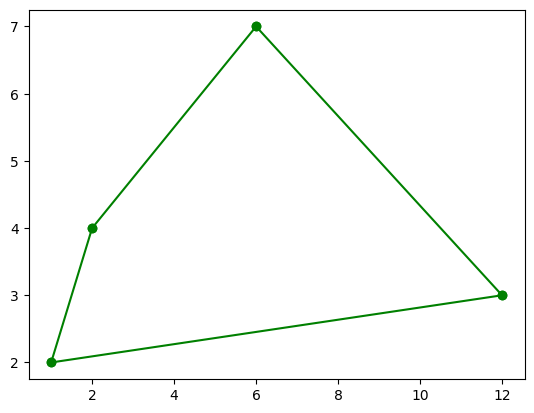

In [166]:
segtest = [Segment(Point(1, 2), Point(2, 4)), Segment(Point(2, 4), Point(6, 7)), Segment(Point(6, 7), Point(12, 3)), Segment(Point(12, 3), Point(1, 2))]
plotSegments(segtest)
lineSweep(segtest)

# Model Functions

In [167]:
#função para aplicar o modelo de classificação em um conjunto de pontos
def classifyPoints(p1, p2, points, targetOrientation):
	isTargetArray = []
	for p in points:
		orientation = getOrientation(p, p1, p2)
		if orientation == targetOrientation:
			isTargetArray.append((True))
		else:
			isTargetArray.append((False))
	return isTargetArray

In [168]:
def separateTesting(data):
	testing = []
	testNum = len(data.data) // 3 # 30% of the data is used for testing
	for i in range(0, testNum):
		index = random.randint(0, len(data.data) - 1) # Get random row
		aux = (data.data[index], data.target[index]) # Save as tuple with data and target
		testing.append(aux)
		data.data = np.delete(data.data, index, 0) # Delete row from data
		data.target = np.delete(data.target, index, 0) # Delete row from target
	return data, testing

In [235]:
def evaluateModel(model, testing):
	modelInfo = model[0]
	target = model[1]
	targetName = model[2]

	hull1 = modelInfo[0]
	perpSegment = modelInfo[5]

	targetPoint = hull1.points[0]
	perpInit = perpSegment.p1
	perpEnd = perpSegment.p2

	targetOrientation = getOrientation(targetPoint, perpInit, perpEnd)

	truePositives = 0
	falsePositives = 0
	falseNegatives = 0

	testingPoints = []
	for i in range(0, len(testing)):
		testingPoints.append(Point(testing[i][0][0], testing[i][0][1]))


	isTargetArray = classifyPoints(perpInit, perpEnd, testingPoints, targetOrientation)
	for i in range(0, len(isTargetArray)):
		if isTargetArray[i] == True:
			if testing[i][1] == target:
				truePositives += 1
			else:
				falsePositives += 1
		else:
			if testing[i][1] == target:
				falseNegatives += 1

	if truePositives + falsePositives == 0:
		precision = 0
	else:
		precision = truePositives / (truePositives + falsePositives)
	if truePositives + falseNegatives == 0:
		recall = 0
	else:
		recall = truePositives / (truePositives + falseNegatives)
	if precision + recall == 0:
		f1Score = 0
	else:
		f1Score = 2 * precision * recall / (precision + recall)

	# plt = plotModelTesting(modelInfo, testing, target)

	return ('Precision: ' + str(precision), 'Recall: ' + str(recall), 'F1 Score: ' + str(f1Score))




# Auto Process dataset

In [170]:
def convertCSVFromURL(url):
	df = pd.read_csv(url)
	# copy last column to target
	target = df[df.columns[-1]].to_numpy()
	# set target_name to last column name
	target_names = [df.columns[-1]]
	# remove last column from data
	df = df.drop(df.columns[-1], axis=1)
	# make array feature_names with all column names
	feature_names = df.columns
	# create data array, in which each row is a sample and each column is a feature
	data = df.to_numpy()
	# create Bunch object
	bunch = Bunch(data=data, target=target, target_names=target_names, feature_names=feature_names)
	return bunch

In [171]:
def PCA2Dim(data):
	pca = sklearn.decomposition.PCA(n_components=2)
	pca.fit(data)
	return pca.transform(data)

In [172]:
def getDistinctTargets(data):
	targets = []
	for i in range(0, len(data.target)):
		if data.target[i] not in targets:
			targets.append(data.target[i])
	return targets

In [173]:
def separateByTarget(data, targetIndex):
	hasIt = []
	doesntHaveIt = []
	for i in range(len(data.target)):
		x = data.data[i][0]
		y = data.data[i][1]
		p = Point(x, y)
		if data.target[i] == targetIndex:
			hasIt.append(p)
		else:
			doesntHaveIt.append(p)
	return hasIt, doesntHaveIt

In [174]:
def checkLinearSeparationAllTargets(data, showCombinationHull):
	models = []
	possibleTargets = getDistinctTargets(data)
	for i in possibleTargets:
		targetName = i
		if len(possibleTargets) == len(data.target_names):
			targetName = (data.target_names[i])
		hasTarget, doesntHaveTarget = separateByTarget(data, i)
		if hasTarget == []:
			print(f'There are no points with target index {i}')
		elif len(hasTarget) < 3:
			print(f'Cannot create hull with target index {i}')
		elif doesntHaveTarget == []:
			print(f'There are no points without target index {i}')
		elif len(doesntHaveTarget) < 3:
			print(f'Cannot create hull without target index {i}')
		else:
			aux = checkLinearSeparation(hasTarget, doesntHaveTarget, targetName, showCombinationHull)
			if aux[0]:
				models.append((aux[1], i, targetName))
	return models

# Check separation, create and evaluate models

In [191]:
def testDataset(data):
	data.data = PCA2Dim(data.data)
	training, testing = separateTesting(data)
	models = checkLinearSeparationAllTargets(training, False)

	if len(models) == 0:
		print('The dataset is not linearly separable')
		return None
		
	modelEvals = []
	for m in models:
		aux = evaluateModel(m, testing)
		modelEvals.append(aux)
		plotTest(m, testing)
	return (models, modelEvals)

# Plotting

In [181]:
def plotTest(model, testing):
	modelInfo = model[0]
	target = model[1]
	targetName = model[2]

	hull1 = modelInfo[0]
	hull2 = modelInfo[1]
	c1 = modelInfo[2]
	c2 = modelInfo[3]
	midpoint = modelInfo[4]
	perpSegment = modelInfo[5]

	# Plot hull1
	plotPoints(hull1.points, 'bo', 5)
	plotPoints(hull1.inside, 'bo', 2)
	for s in hull1.segments:
		plt.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], 'b-')

	# Plot hull2
	plotPoints(hull2.points, 'ro', 5)
	plotPoints(hull2.inside, 'ro', 2)
	for s in hull2.segments:
		plt.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], 'r-')

	# Plot closest points and line perpendicular to the segment formed by them
	plotPerpendicularLines(c1, c2, midpoint, perpSegment, True)

	# Plot testing points
	for i in range(len(testing)):
		x = testing[i][0][0]
		y = testing[i][0][1]
		if testing[i][1] == target:
			plt.plot(x, y, 'co', markersize=3)
		else:
			plt.plot(x, y, 'yo', markersize=3)

	plt.axis('equal')

	plt.grid(True)
	plt.show()

# Tests

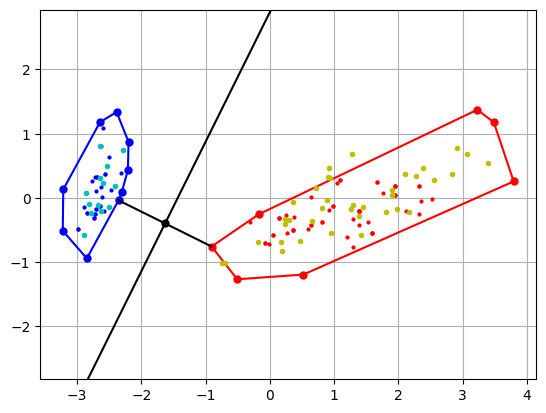

[('Precision: 1.0', 'Recall: 1.0', 'F1 Score: 1.0')]


In [236]:
iris = sklearn.datasets.load_iris()
testData = testDataset(iris)
if testData != None:
	print(testData[1])

In [196]:
wine = sklearn.datasets.load_wine()
testData = testDataset(wine)
if testData != None:
	print(testData[1])

The dataset is not linearly separable


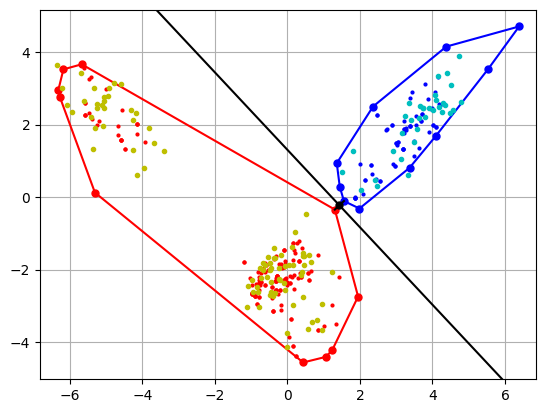

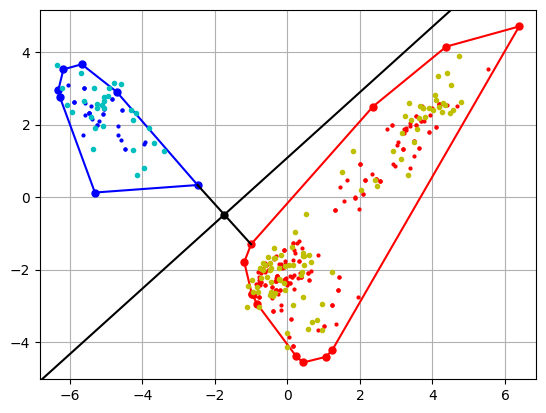

[(1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]


In [197]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/dermatology.prepared.csv'
dermatology = convertCSVFromURL(url)
testData = testDataset(dermatology)
if testData != None:
	print(testData[1])

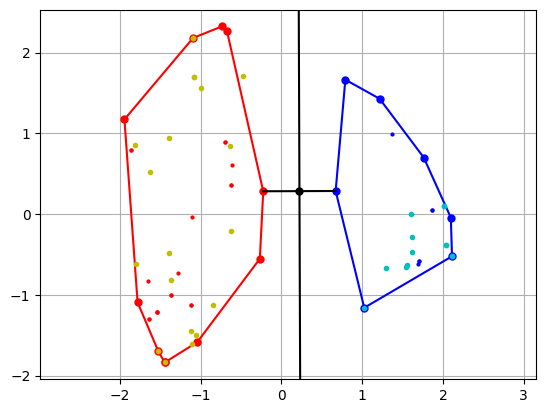

[(1.0, 1.0, 1.0)]


In [200]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/zoo.prepared.csv'
zoo = convertCSVFromURL(url)
testData = testDataset(zoo)
if testData != None:
	print(testData[1])

Cannot create hull with target index normal


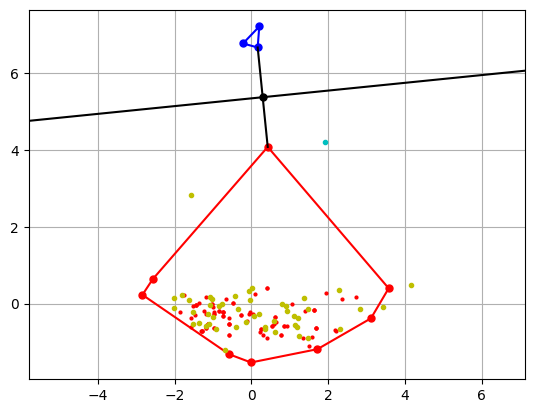

[(0, 0.0, 0)]


In [234]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/lymphography.prepared.csv'
lymphography = convertCSVFromURL(url)
testData = testDataset(lymphography)
if testData != None:
	print(testData[1])